# **New York City Taxi Trip Data**

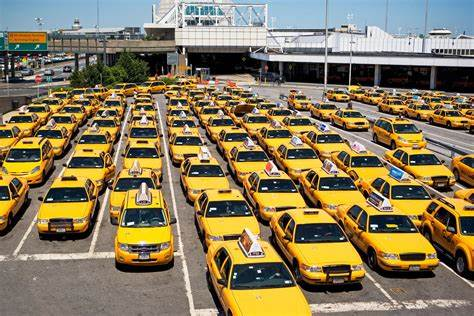

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

fig_path = '/content/drive/MyDrive/DataMining/Figures/'
data_path = '/content/drive/MyDrive/DataMining/Dataset/'
cleaned_data = '/content/drive/MyDrive/DataMining/Dataset/Taxi_Trip_Cleaned_Data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(data_path + "taxi_trip_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   vendor_id            int64  
 1   pickup_datetime      object 
 2   dropoff_datetime     object 
 3   passenger_count      int64  
 4   trip_distance        float64
 5   rate_code            int64  
 6   store_and_fwd_flag   object 
 7   payment_type         int64  
 8   fare_amount          float64
 9   extra                float64
 10  mta_tax              float64
 11  tip_amount           float64
 12  tolls_amount         float64
 13  imp_surcharge        float64
 14  total_amount         float64
 15  pickup_location_id   int64  
 16  dropoff_location_id  int64  
dtypes: float64(8), int64(6), object(3)
memory usage: 1.3+ GB


In [ ]:
# Afficher les premier lignes
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id
0,2,2018-03-29 13:37:13,2018-03-29 14:17:01,1,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1
1,2,2018-03-29 13:37:18,2018-03-29 14:15:33,1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230
2,2,2018-03-29 13:26:57,2018-03-29 13:28:03,1,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231
3,2,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138
4,2,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138


# Intro  

L'objectif de ce Notebook est de nettoyer et d'analyser les données disponibles dans le but de les utiliser ultérieurement dans des algorithmes d'apprentissage automatique pour générer des prédictions de tarifs pour des trajets et des usagers potentiels.

L'étape la plus importante ici est de définir clairement ce qui sera prédit, puis d'explorer ce qui sera et pourrait être nécessaire pour effectuer cette prédiction. Une fois ces valeurs définies, le processus de nettoyage des données peut commencer à éliminer les valeurs aberrantes, les valeurs manquantes et autres bruits susceptibles d'affecter les résultats de l'algorithme.

## ML Goal  

À première vue, il peut sembler évident que l'algorithme d'apprentissage automatique devrait prédire le montant du tarif, mais cela peut en fait être réalisé sans aucun apprentissage automatique. En fait, il est tout à fait possible de prédire le montant total sans apprentissage automatique ! Cela demanderait un effort considérable, mais cela ne veut pas dire que c'est impossible. Que fait donc le modèle d'apprentissage automatique ?

L'objectif du modèle est de rendre ces prédictions aussi faciles que possible.Plutôt que de rechercher nous-mêmes les itinéraires, les péages, les frais, l'heure de la journée et toutes les autres variables, nous voulons simplement introduire des variables spécifiques et générer un résultat aussi proche que possible du prix réel du billet.
Le montant de la course est facile à calculer.D'après le site Internet du gouvernement de New York consacré aux tarifs des taxis, le tarif d'un taxi se calcule comme suit : **2 \$** de frais de prise en charge initiaux, **50 cents** par personne et par jour. **50 \$** de frais de prise en charge, **50 cents** par mile lorsque la vitesse est supérieure à **12mph**, et **50 cents** par minute lorsque la vitesse est inférieure à **12mph**, plus **50 cents** de supplément MTA pour tous les trajets qui se terminent dans la ville de New York ou dans les comtés de Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange ou Putnam, **30 cents** de supplément d'amélioration, **50 cents** pour la nuit (de **20h** à **6h**) et **1,00 \$** pour les heures de pointe, entre **16h** et **20h** les jours de semaine. Le site mentionne également une taxe variable pour certains trajets se terminant ou passant par Manhattan, au sud de la 96e rue, mais comme nous le verrons bientôt, nos données ne tiennent pas compte de ce facteur. Il s'agit peut-être d'une règle plus récente depuis 2019, ou pour une raison quelconque, elle n'a pas été incluse dans la collecte de données initiale.

Ce calcul n'est pas difficile à effectuer, mais il ne nous donne que le montant du tarif après la fin du voyage, et ce n'est pas ce que nous recherchons. Nous voulons savoir quel sera le montant du tarif avant le voyage ! Cela signifie que d'autres fonctionnalités vont entrer en ligne de compte.Il est important de garder à l'esprit que le site Web mentionne également que le nombre de passagers n'a aucune incidence sur le montant du tarif, ce qui signifie que nous pouvons ignorer ces données immédiatement. Bien qu'elles soient intéressantes, elles ne sont d'aucune utilité pour le modèle.

La première chose, et probablement la plus évidente, est de déterminer les lieux de prise en charge et de dépose. Les trajets qui ont suivi le même chemin dans le passé emprunteront probablement des itinéraires similaires, et les trajets effectués aux mêmes heures de la journée prendront probablement à peu près la même durée. Cela nous donne une sorte de moyenne mobile pour la distance et le temps afin de faciliter le calcul. Ce que cela ne nous donne pas, c'est la proportion de cette distance qui est parcourue dans les embouteillages, à une vitesse inférieure à 12 miles par heure, ou à une vitesse normale supérieure à 12 miles par heure, et cela ne tient pas non plus compte du fait d'être assis aux feux rouges.  
Ces valeurs sont difficiles à prendre en compte. Si l'analyse des données à l'aide de graphiques et d'autres éléments visuels permet de déceler des tendances, elle ne permet pas de faire des prédictions très mathématiques ou reproductibles. Nous avons besoin que le modèle détecte ces schémas rapidement et de manière répétée pour obtenir les prédictions les plus précises possibles, ce qui signifie que certaines données, telles que les heures de début et de fin, doivent être décomposées en morceaux plus faciles à lire pour une machine, tels que le nombre de minutes par trajet, le mois, le jour, le jour de la semaine et l'année (séparément). Dans un ensemble de données plus large contenant plus que 2019, cela pourrait également permettre au modèle de détecter des modèles dans l'heure de l'année et l'heure du mois. Dans le cadre de ce projet, nous ne pourrons calculer des modèles que pour le mois, par exemple des trajets plus longs en décembre en raison d'une circulation plus dense, ou pour le jour de la semaine, par exemple des jours de semaine plus chargés parce qu'ils correspondent à des horaires de travail normaux.  

## Planification des caractéristiques
Voici les caractéristiques du jeu de données actuel que nous conserverons, ainsi que quelques-unes qui devront être créées sur la base d'autres caractéristiques, ce que l'on appelle l'ingénierie des caractéristiques :
- pickup_timestamp  
- dropoff_timestamp  
- trip_distance  
- fare_amount  
- extra  
- mta_tax  
- imp_surcharge  
- total_amount  
- pickup_location_id  
- dropoff_location_id  

Si la raison pour laquelle j'ai choisi de conserver ces variables devrait s'expliquer d'elle-même, certains pourraient se demander "pourquoi pas le montant du pourboire".
Eh bien, le montant du pourboire n'est inclus que dans le montant total, et c'est ce que j'aime appeler "sauvage". Les coureurs peuvent payer ce qu'ils veulent en pourboires, et ces pourboires sont uniquement des pourboires payés par carte de crédit, et non en espèces. Cela signifie qu'il n'y aura aucune corrélation entre le montant du pourboire et le montant total, si ce n'est qu'il sera ajouté au prix du billet. Les pourboires ne devraient pas jouer un rôle dans la prédiction d'un tarif parce qu'ils sont entièrement volontaires et ne contiennent aucun modèle réel.  

Il y a aussi des valeurs telles que "rate_code", qui est définie par le collecteur comme le code tarifaire en vigueur à la fin du voyage, et qui énumère ensuite des lieux spécifiques, qui se trouvent être mentionnés ci-dessus dans la partie concernant certains frais pour certaines zones. Il est très possible que cette valeur soit nécessaire pour une prédiction précise, mais nous devrons explorer davantage pour déterminer si c'est vrai ou non. Il en va de même pour tous les autres points de données restants, alors commençons l'exploration initiale.



## Exploration  

L'un des outils les plus puissants que j'ai trouvés pour calculer et visualiser rapidement la corrélation entre différentes valeurs est une matrice de corrélation ou une carte thermique.  
La matrice de corrélation calcule comment le changement d'une valeur affecte le changement de l'autre valeur et attribue une valeur comprise entre -1 et 1 à cette corrélation.  
Avant de poursuivre, examinons la signification de ces valeurs de corrélation :  

-1 Une corrélation négative très forte, lorsque la valeur A évolue dans une direction, la valeur B évolue dans la direction opposée.  
0 Aucune corrélation entre les valeurs A et B, lorsque l'une bouge, l'autre n'est pas affectée.  
1 Une corrélation positive très forte, comme vous pouvez le deviner, c'est le contraire de la corrélation négative ci-dessus. Lorsque la valeur A évolue dans une direction, la valeur B suit dans la même direction.  

Il est important de se rappeler que cette valeur n'est pas liée au taux de changement, mais seulement à la direction du changement. La valeur A augmente et la valeur B reste stable, augmente ou diminue.  

Générons cette matrice et représentons-la sous forme de carte thermique !

In [ ]:
# Generer la matrice de correlation
corr = df.corr()

<ipython-input-7-9ffcd86bb90d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


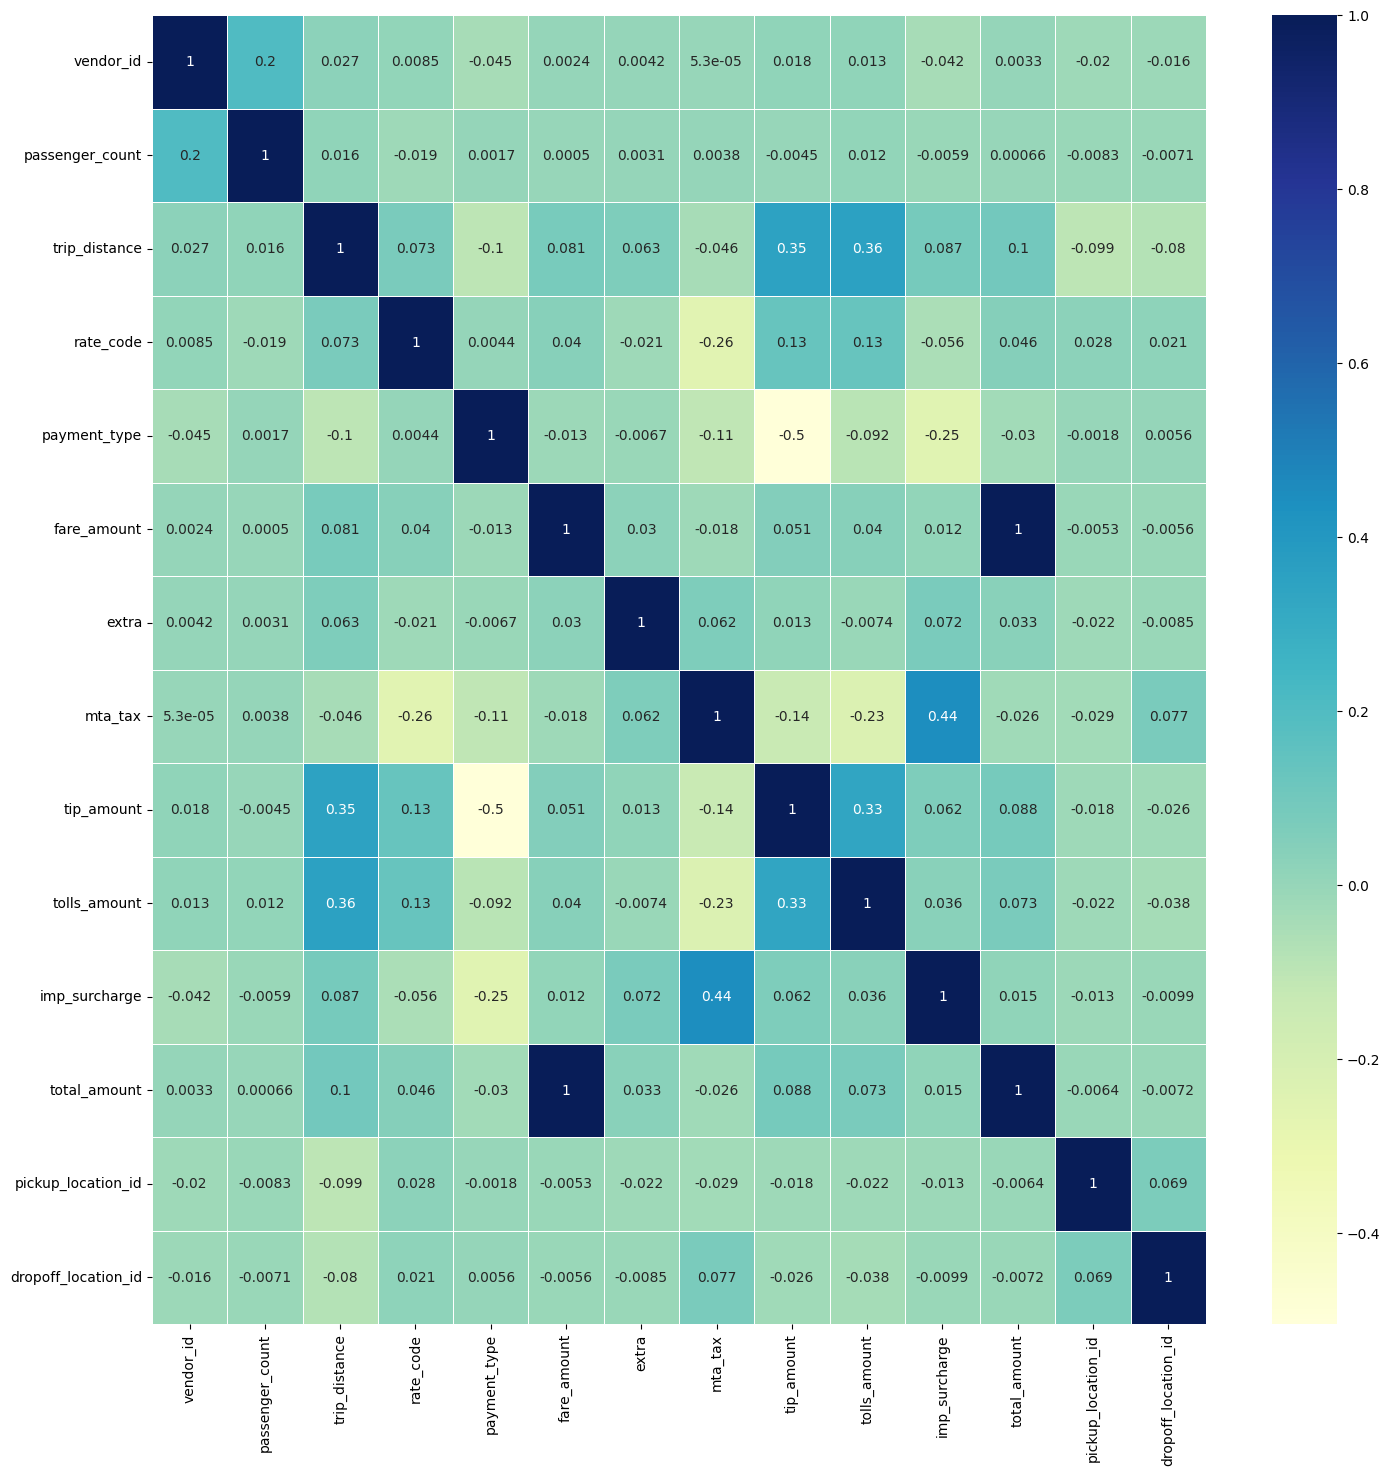

In [ ]:
# Drawing the heatmap
col = df.shape[1]
fig, ax = plt.subplots(figsize=(col,col))
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, linewidths=0.5);

In [ ]:
fig.savefig(fig_path + 'Matrice de correlation.png', dpi=700)
corr = []

Nous avons déjà une liste de valeurs connues que nous devons conserver, les seules valeurs restantes sont :
- **vendor_id** - Cette valeur ne sera certainement pas utilisée pour notre modèle.
- **rate_code** -  Le code tarifaire à la fin du voyage. Utilisé probablement pour suivre certains frais. Il y a une corrélation avec les péages et les pourboires, mais pas avec grand-chose d'autre.
- **sotre_and_fwd_flag** - Il s'agit simplement d'un drapeau qui indique si une valeur a été stockée dans la mémoire du véhicule avant d'être enregistrée en raison d'un manque de connexion Internet. Cette valeur est inutile pour nous, mais elle est actuellement stockée sous forme de chaîne de caractères et sa conversion en une valeur pouvant apparaître ultérieurement dans une matrice de corrélation pourrait s'avérer utile. Bien que cela soit peu probable, il est possible que les valeurs soient différentes de celles qui ne sont pas stockées en mémoire, par exemple qu'elles comportent un plus grand nombre d'erreurs, ou qu'un processus de téléchargement modifie les valeurs d'une manière inattendue. Je vais garder cela pour l'instant et vérifier les corrélations plus tard.

En fin de compte, nous ne supprimons qu'une seule colonne dès le départ, à savoir l'identifiant du fournisseur. Nous avons beaucoup de données avec lesquelles travailler, donc tout petit changement aura un impact plus important que d'habitude, donc je vais laisser tomber cette colonne maintenant et je parlerai des prochaines étapes.

In [ ]:
data = df.drop('vendor_id', axis=1)
df = df.shape
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id
0,2018-03-29 13:37:13,2018-03-29 14:17:01,1,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1
1,2018-03-29 13:37:18,2018-03-29 14:15:33,1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230
2,2018-03-29 13:26:57,2018-03-29 13:28:03,1,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231
3,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138
4,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138


## Cleaning  

Passons maintenant aux choses sérieuses !
Il est tentant de passer directement à l'ingénierie et à l'analyse des fonctionnalités à ce stade, mais l'analyse d'un jeu de données "sale" fait perdre beaucoup de temps à la création d'une analyse qui peut s'avérer très différente une fois les problèmes résolus, et l'ingénierie de nouvelles fonctionnalités peut causer des maux de tête en raison d'erreurs telles que des fonctions mathématiques qui ne fonctionnent pas (imaginez diviser par zéro !) ou des données manquantes.

Passons en revue les étapes de nettoyage qui doivent être réalisées avant de commencer : (Pandas fait en fait beaucoup pour nous en chargeant simplement les données dans un cadre de données).
1. Supprimer les lignes en double - Avec précaution, car nous ne voulons supprimer que les voyages en double, et non les doublons dans les valeurs elles-mêmes. Il n'est pas nécessaire que ces valeurs soient uniques.
2. Vérifier les valeurs manquantes  
3. Vérifiez la présence de zéros et de chaînes vides. Ces valeurs ne sont pas "manquantes" mais ne sont toujours pas valides. Très peu de colonnes dans ces données ont des zéros valides.  
4. Validez le formatage des données, en particulier les dates  
5. Supprimer et normaliser les chaînes de caractères - nos données ne contiennent pas de chaînes de caractères, nous pouvons donc sauter cette étape.

In [ ]:
# Supprimer les doublons - Première étape facile pour réduire la taille des données, ce qui rend les étapes suivantes plus rapides
# A partir de maintenant, je vais renommer le dataframe de df en td pour les données temporaires, afin de ne modifier le dataframe original que bien plus tard.
data = data.drop_duplicates()
# 1% dropped
print(f"{df[0] - data.shape[0]} lignes doubles.  {(df[0] - data.shape[0]) / df[0] * 100}%")
print(f"{data.shape[0]} rows remain.")

607571 lignes doubles.  6.07571%
9392429 rows remain.


In [ ]:
data.shape

(9392429, 16)

In [ ]:
# Chercher les valeurs manquantes
for col in data.columns:
    missing = data[col].isna().sum()
    print(f"Valeurs nulls dans la colonne :  {col} -> {missing}")

Valeurs nulls dans la colonne :  pickup_datetime -> 0
Valeurs nulls dans la colonne :  dropoff_datetime -> 0
Valeurs nulls dans la colonne :  passenger_count -> 0
Valeurs nulls dans la colonne :  trip_distance -> 0
Valeurs nulls dans la colonne :  rate_code -> 0
Valeurs nulls dans la colonne :  store_and_fwd_flag -> 0
Valeurs nulls dans la colonne :  payment_type -> 0
Valeurs nulls dans la colonne :  fare_amount -> 0
Valeurs nulls dans la colonne :  extra -> 0
Valeurs nulls dans la colonne :  mta_tax -> 0
Valeurs nulls dans la colonne :  tip_amount -> 0
Valeurs nulls dans la colonne :  tolls_amount -> 0
Valeurs nulls dans la colonne :  imp_surcharge -> 0
Valeurs nulls dans la colonne :  total_amount -> 0
Valeurs nulls dans la colonne :  pickup_location_id -> 0
Valeurs nulls dans la colonne :  dropoff_location_id -> 0


In [ ]:
# Chercher les valeurs '0'
def check_for_zeros(data):
    for col in data.columns:
        zeros = data[data[col] == 0].shape[0]
        print(f"Nombre de Zeros dans la colonne :   {col} -> {zeros} avec {zeros/data.shape[0] * 100}%")

check_for_zeros(data)

Nombre de Zeros dans la colonne :   pickup_datetime -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   dropoff_datetime -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   passenger_count -> 85779 avec 0.9132781307157074%
Nombre de Zeros dans la colonne :   trip_distance -> 264896 avec 2.8203141061806267%
Nombre de Zeros dans la colonne :   rate_code -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   store_and_fwd_flag -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   payment_type -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   fare_amount -> 12176 avec 0.1296363273014893%
Nombre de Zeros dans la colonne :   extra -> 5048008 avec 53.74550076449872%
Nombre de Zeros dans la colonne :   mta_tax -> 285657 avec 3.041353839352951%
Nombre de Zeros dans la colonne :   tip_amount -> 2062555 avec 21.95976142060802%
Nombre de Zeros dans la colonne :   tolls_amount -> 6253748 avec 66.58286157925708%
Nombre de Zeros dans la colonne :   imp_surcharge -> 12433 avec 0.1323725736973897%
Nombre de Ze

Ok, premier problème.
passenger_count, trip_distance, far_amount et total_amount contiennent tous des zéros. Cela ne semble pas représenter une grande partie des données globales. Je vérifierais normalement le pourcentage de l'ensemble des données que ces valeurs représentent, mais il a déjà été déterminé que passenger_count n'était pas conservé et le reste des informations ne peut pas vraiment être complété par des méthodes mathématiques parce que chacune des valeurs dépend de l'autre pour être calculée. Sans la distance, nous ne pouvons pas déterminer le montant du tarif, et même avec la distance, il est impossible de savoir quels kilomètres ont été parcourus au-dessus du seuil de 12mph et quels kilomètres ont été parcourus en dessous. Il n'y a pas vraiment d'autre choix que d'abandonner ces lignes, mais le montant total peut être corrigé en additionnant simplement toutes les valeurs des colonnes de frais, je vais donc conserver et corriger ces lignes.

In [ ]:
# Suppression des lignes contenant des valeurs 0 dans les colonnes où la valeur 0 n'est pas autorisée
data = data.drop(['passenger_count'], axis=1)
data = data[data['trip_distance'] > 0]
data = data[data['fare_amount'] > 0]

check_for_zeros(data)

Nombre de Zeros dans la colonne :   pickup_datetime -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   dropoff_datetime -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   trip_distance -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   rate_code -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   store_and_fwd_flag -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   payment_type -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   fare_amount -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   extra -> 4836000 avec 53.14606342734304%
Nombre de Zeros dans la colonne :   mta_tax -> 216469 avec 2.378923739465161%
Nombre de Zeros dans la colonne :   tip_amount -> 1886004 avec 20.726569108400057%
Nombre de Zeros dans la colonne :   tolls_amount -> 5980138 avec 65.71976704968245%
Nombre de Zeros dans la colonne :   imp_surcharge -> 1418 avec 0.015583357721251535%
Nombre de Zeros dans la colonne :   total_amount -> 0 avec 0.0%
Nombre de Zeros dans la colonne :   pickup_location_id -> 0 avec 0.0%
N

Après avoir supprimé les lignes dont les valeurs sont nulles dans d'autres colonnes, il n'y a plus de zéros dans total_amount, aucune correction n'est donc nécessaire !

In [ ]:
# Vérification de la quantité de données originales conservées
remaining = data.shape[0] / df[0] * 100
print(f"Quantité restante dans dataset: {remaining}%")

Quantité restante dans dataset: 90.99450999999999%


Il est maintenant temps de s'occuper du formatage des données.  
Pandas s'en charge en grande partie en assignant des dtyps à chaque colonne. Nous recevrions un avertissement DtypeWarning si plusieurs types existaient dans la même colonne.  
Il ne reste plus qu'à s'assurer que les dates sont toutes lisibles et qu'elles existent dans le même format, comme mm/jj/aaaa, par exemple.

In [ ]:
# La conversion en un objet datetime Python/Pandas garantit que les données sont des dates valides. Nous pouvons ensuite passer à l'exploration des dates disponibles.
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

print('Done.')

Done.


Avant d'explorer les dates, il sera plus facile de diviser les dates en colonnes significatives. Nous aurons également besoin de ces valeurs pour notre modèle, comme mentionné ci-dessus, c'est donc le bon moment pour le faire !  

La seule information que nous avons besoin de conserver est l'heure, et encore, seulement pour calculer la durée du trajet. Par conséquent, je pense qu'il est plus logique de calculer cette valeur maintenant. Nous l'enregistrerons en tant que secondes.

In [ ]:
data['year'] = pd.to_datetime(data['pickup_datetime']).dt.year
data['month'] = pd.to_datetime(data['pickup_datetime']).dt.month
data['day'] = pd.to_datetime(data['pickup_datetime']).dt.day
data['day_of_week'] = pd.to_datetime(data['pickup_datetime']).dt.dayofweek
data['hour_of_day'] = pd.to_datetime(data['pickup_datetime']).dt.hour

print('Done')

Done


**Création de  Trip Duration**

Après avoir appris comment NumPy pouvait remplacer df.apply(), ce code est devenu mon préféré. NumPy, c'est génial !

In [ ]:
# Conversion des colonnes datetime en tableau numpy pour la vectorisation
pickup_array = data['pickup_datetime'].values
dropoff_array = data['dropoff_datetime'].values

# L'obtention du nouveau timedelta prend moins d'une seconde, contre plus de 15 minutes avec apply().
trip_duration = np.subtract(dropoff_array, pickup_array)
pickup_array = []
dropoff_array = []
# Ajout du tableau résultant à l'image de données dans la colonne trip_duration
data['trip_duration'] = pd.Series(trip_duration)

# Conversion du timedelta en nombre de secondes
data['trip_duration'] = data['trip_duration'].dt.total_seconds()
trip_duration = []
# Preview the results
data.head()

,pickup_datetime,dropoff_datetime,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,...,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
0,2018-03-29 13:37:13,2018-03-29 14:17:01,18.15,3,N,1,70.0,0.0,0.0,16.16,...,0.3,96.96,161,1,2018,3,29,3,13,2388.0
1,2018-03-29 13:37:18,2018-03-29 14:15:33,4.59,1,N,1,25.0,0.0,0.5,5.16,...,0.3,30.96,13,230,2018,3,29,3,13,2295.0
2,2018-03-29 13:26:57,2018-03-29 13:28:03,0.30,1,N,1,3.0,0.0,0.5,0.76,...,0.3,4.56,231,231,2018,3,29,3,13,66.0
3,2018-03-29 13:07:48,2018-03-29 14:03:05,16.97,1,N,1,49.5,0.0,0.5,5.61,...,0.3,61.67,231,138,2018,3,29,3,13,3317.0
4,2018-03-29 14:19:11,2018-03-29 15:19:59,14.45,1,N,1,45.5,0.0,0.5,10.41,...,0.3,62.47,87,138,2018,3,29,3,14,3648.0


Maintenant, les colonnes de dates peuvent être entièrement supprimées !  

Faisons-le avant de passer à autre chose, nous sommes sur une lancée avec les dates de toute façon

In [ ]:
data.drop(['pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)

In [ ]:
data.head()

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
0,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1,2018,3,29,3,13,2388.0
1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230,2018,3,29,3,13,2295.0
2,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231,2018,3,29,3,13,66.0
3,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138,2018,3,29,3,13,3317.0
4,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138,2018,3,29,3,14,3648.0


Maintenant que les dates ont été correctement ventilées et que la durée de nos voyages a été déterminée, nous pouvons passer à des choses plus importantes et plus intéressantes, c'est-à-dire au nettoyage !
Tout d'abord, tous les voyages dont la durée est égale à 0 doivent être supprimés. Ces voyages ne seront pas utiles et sont certainement dus à une erreur de saisie.

Ensuite, nous pouvons étudier les années disponibles dans cet ensemble de données, la part de chaque année dans l'ensemble de données, et commencer à étudier si nous devrions garder toutes les années, ou seulement certaines années en visualisant les tendances dans les montants des tarifs par rapport à la durée et à la distance des trajets.

In [ ]:
data = data[data['trip_duration'] > 0]

In [ ]:
list_of_years = data.year.unique()
print(list_of_years)

[2018 2009 2017 2019 2008 2020 2003 2002 2001 2029 2032]


In [ ]:
for year in list_of_years:
    year_amount = data[data['year'] == year].shape[0]
    total_amount = data.shape[0]

    print(f"{year} représente {(year_amount / total_amount) * 100}% de dataset")

2018 représente 99.99841696039846% de dataset
2009 représente 0.0006356143854646263% de dataset
2017 représente 0.00020387631231884242% de dataset
2019 représente 0.00014391269104859462% de dataset
2008 représente 0.0004917016944160317% de dataset
2020 représente 1.1992724254049552e-05% de dataset
2003 représente 2.3985448508099104e-05% de dataset
2002 représente 2.3985448508099104e-05% de dataset
2001 représente 2.3985448508099104e-05% de dataset
2029 représente 1.1992724254049552e-05% de dataset
2032 représente 1.1992724254049552e-05% de dataset


# Des résultats inattendus
Il est clair que cet ensemble de données est TRÈS FORTEMENT pondéré vers 2018. Pour cette raison, l'élimination de tout ce qui date d'avant 2018 peut aider à éviter de biaiser les données vers des tendances anciennes, tandis que le maintien de tout ce qui est plus récent que 2018 pourrait révéler de nouvelles tendances, bien que je ne pense pas que cela soit très utile. Si un ensemble de données de cette taille est composé à 99 % de la même année, il est probable que les voyages des années plus récentes soient soit des données non valides lors de la collecte, soit suffisamment incomplètes pour montrer des tendances.

Bien que ce soit un peu dommage, car j'aimerais voir des données plus récentes, cela rend la décision très facile à prendre. Gardez 2018, laissez tomber le reste. Nous perdrons moins de 0,01 % de l'ensemble des données et éviterons toute distorsion basée sur des données potentiellement invalides dans d'autres colonnes de ces années.

Après avoir supprimé ces lignes, je vais commencer à vérifier les derniers éléments de nos données, en commençant par le montant total. Cette valeur doit être égale à la somme des éléments suivants : fare_amount, mta_tax, tip_amount, tolls_amount, imp_surcharge et extra.

In [ ]:
data = data[data['year'] == 2018]

data.describe()

,trip_distance,rate_code,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
count,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8338257.0,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06
mean,9.120187e+00,1.154223e+00,1.180907e+00,3.178215e+01,3.469645e-01,4.882261e-01,5.526390e+00,2.174295e+00,2.999538e-01,4.062672e+01,1.528662e+02,1.476428e+02,2018.0,6.459984e+00,1.576347e+01,2.950375e+00,1.380998e+01,2.210049e+03
std,5.879868e+00,6.330880e-01,4.073165e-01,7.560952e+01,5.659283e-01,8.265593e-02,4.568232e+00,3.748963e+00,3.744167e-03,7.668925e+01,6.017347e+01,7.560037e+01,0.0,3.423810e+00,8.640502e+00,1.930177e+00,6.231820e+00,4.865978e+03
min,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e-02,-8.000000e+01,0.000000e+00,0.000000e+00,-5.760000e+00,0.000000e+00,3.100000e-01,1.000000e+00,1.000000e+00,2018.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,6.030000e+00,1.000000e+00,1.000000e+00,2.350000e+01,0.000000e+00,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,2.915000e+01,1.320000e+02,8.800000e+01,2018.0,3.000000e+00,9.000000e+00,1.000000e+00,1.000000e+01,1.403000e+03
50%,8.600000e+00,1.000000e+00,1.000000e+00,2.900000e+01,0.000000e+00,5.000000e-01,5.550000e+00,0.000000e+00,3.000000e-01,3.755000e+01,1.380000e+02,1.420000e+02,2018.0,6.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01,1.835000e+03
75%,1.121000e+01,1.000000e+00,1.000000e+00,3.700000e+01,5.000000e-01,5.000000e-01,7.910000e+00,5.760000e+00,3.000000e-01,4.901000e+01,1.860000e+02,2.290000e+02,2018.0,1.000000e+01,2.300000e+01,5.000000e+00,1.900000e+01,2.348000e+03
max,7.655760e+03,9.900000e+01,4.000000e+00,1.874365e+05,2.020000e+01,8.080000e+01,4.220000e+02,9.182500e+02,6.000000e-01,1.874378e+05,2.650000e+02,2.650000e+02,2018.0,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01,3.200310e+05


Supprimer les colonnes de Fare avec des valeurs négatives

In [ ]:
init_count = len(data)
data = data[data['fare_amount'] >= 0]
data = data[data['extra'] >= 0]
data = data[data['mta_tax'] >= 0]
data = data[data['tip_amount'] >= 0]
data = data[data['imp_surcharge'] >= 0]
data = data[data['tolls_amount'] >= 0]
final_count = len(data)

print(f"Fraction of dataframe retained: {final_count / init_count * 100}%")

Fraction of dataframe retained: 99.99989206377305%


In [ ]:
# Calculer les montants totaux et supprimer les lignes dont les valeurs ne s'additionnent pas...
fare = data['fare_amount'].values
extra = np.add(fare, data['extra'].values)
mta_tax = np.add(extra, data['mta_tax'].values)
tip_amount = np.add(mta_tax, data['tip_amount'].values)
imp_surcharge = np.add(tip_amount, data['imp_surcharge'].values)
calculated_total_amount = np.add(imp_surcharge, data['tolls_amount'].values)

data['calculated_total_amount'] = pd.Series(calculated_total_amount)

# valider le total calculé en additionnant manuellement toutes les colonnes pertinentes et en les comparant à la colonne calculée
data.head(10)

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
0,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1,2018,3,29,3,13,2388.0,96.96
1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230,2018,3,29,3,13,2295.0,30.96
2,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231,2018,3,29,3,13,66.0,4.56
3,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138,2018,3,29,3,13,3317.0,61.67
4,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138,2018,3,29,3,14,3648.0,62.47
5,11.60,1,N,1,42.0,0.0,0.5,14.57,5.76,0.3,63.13,68,138,2018,3,29,3,14,3540.0,63.13
6,5.80,1,N,1,24.0,0.0,0.5,4.95,0.00,0.3,29.75,100,87,2018,3,29,3,14,1608.0,29.75
7,3.38,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,144,161,2018,3,29,3,15,2554.0,30.96
8,16.98,3,N,1,85.0,0.0,0.0,15.00,12.50,0.3,112.80,87,1,2018,3,29,3,15,5267.0,112.80
9,4.99,1,N,1,22.0,1.0,0.5,4.76,0.00,0.3,28.56,13,161,2018,3,29,3,16,1810.0,28.56


In [ ]:
# Supprimer tout ce qui n'est pas correct
data = data[data['total_amount'] != data['calculated_total_amount']]

data.head()

,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
3,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138,2018,3,29,3,13,3317.0,61.67
4,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138,2018,3,29,3,14,3648.0,62.47
5,11.60,1,N,1,42.0,0.0,0.5,14.57,5.76,0.3,63.13,68,138,2018,3,29,3,14,3540.0,63.13
10,5.10,1,N,1,26.5,1.0,0.5,5.65,0.00,0.3,33.95,186,33,2018,3,29,3,16,2585.0,33.95
12,11.11,1,N,1,45.5,1.0,0.5,10.61,5.76,0.3,63.67,163,138,2018,3,29,3,16,4521.0,63.67


## Finition

Cette colonne total_amount faisait bien plus que nettoyer les totaux, elle vérifiait en même temps toutes les autres colonnes affectant les totaux. En cas d'erreur dans l'une des colonnes, le total calculé aurait été différent du total calculé. Mta_tax manquante ? Supprimée. Montant des péages incorrect ? Supprimé.

Voilà qui résume à peu près le processus de nettoyage. Bien qu'il y ait encore quelques valeurs qui doivent être examinées plus en détail, comme storoe_et_fwd_flag, tout ce qui se passera à partir de maintenant dépendra fortement de la phase d'exploration pour comprendre et déterminer ce qu'il faut faire avec. Pour l'instant, je vais sauvegarder les données nettoyées au format csv.

In [ ]:
# Enregistrer le dataset dans un autre fichier CSV
data.to_csv(cleaned_data)
print('Done!')

Done!
